In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# df = pd.read_csv('/home/alumnadotarde/Descargas/Bitcoin.csv')
df = pd.read_csv('./bitcoin.csv', delimiter=',')
df.head()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,17.12.2024,"106.138,9","106.053,4","108.244,9","105.350,6","149,37K",+0.08%
1,16.12.2024,"106.057,6","104.479,2","107.767,6","103.351,7","232,66K",+1.55%
2,15.12.2024,"104.443,0","101.417,9","105.120,9","101.234,9","133,99K",+2.98%
3,14.12.2024,"101.417,7","101.423,7","102.633,0","100.626,3","105,31K",-0.01%
4,13.12.2024,"101.426,2","100.008,3","101.891,2","99.214,2","162,40K",+1.42%


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Fecha     4724 non-null   object
 1   Último    4724 non-null   object
 2   Apertura  4724 non-null   object
 3   Máximo    4724 non-null   object
 4   Mínimo    4724 non-null   object
 5   Vol.      4724 non-null   object
 6   % var.    4724 non-null   object
dtypes: object(7)
memory usage: 258.5+ KB


In [4]:
if df['Vol.'].dtype == 'object':  # Limpiar solo si el tipo es texto
    df['Vol.'] = (
        df['Vol.']
        .str.replace('K', '*1e3', regex=False)  # Miles
        .str.replace('M', '*1e6', regex=False)  # Millones
        .str.replace('B', '*1e9', regex=False)  # Miles de millones
        .str.replace('.', '', regex=False)  # Eliminar puntos
        .str.replace(',', '.', regex=False)  # Reemplazar comas por puntos
        .map(eval)  # Evaluar las expresiones matemáticas
    )


In [5]:
for col in ['Último', 'Apertura', 'Máximo', 'Mínimo']:
    if df[col].dtype == 'object':  # Limpiar solo si el tipo es texto
        df[col] = df[col].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)
df.head()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,17.12.2024,106138.9,106053.4,108244.9,105350.6,149370.0,+0.08%
1,16.12.2024,106057.6,104479.2,107767.6,103351.7,232660.0,+1.55%
2,15.12.2024,104443.0,101417.9,105120.9,101234.9,133990.0,+2.98%
3,14.12.2024,101417.7,101423.7,102633.0,100626.3,105310.0,-0.01%
4,13.12.2024,101426.2,100008.3,101891.2,99214.2,162400.0,+1.42%


In [6]:
columns_to_convert = df.columns[df.columns != 'Fecha']  # Seleccionamos todas menos 'Fecha'
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724 entries, 0 to 4723
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Fecha     4724 non-null   object 
 1   Último    4724 non-null   float64
 2   Apertura  4724 non-null   float64
 3   Máximo    4724 non-null   float64
 4   Mínimo    4724 non-null   float64
 5   Vol.      4724 non-null   float64
 6   % var.    0 non-null      float64
dtypes: float64(6), object(1)
memory usage: 258.5+ KB


In [8]:
# Filtrar solo las columnas de tipo float
df_float = df.select_dtypes(include=['float64'])

# Calcular la correlación solo entre columnas de tipo float
print(df_float.corr())


            Último  Apertura    Máximo    Mínimo      Vol.  % var.
Último    1.000000  0.999204  0.999665  0.999572  0.096212     NaN
Apertura  0.999204  1.000000  0.999621  0.999431  0.096821     NaN
Máximo    0.999665  0.999621  1.000000  0.999297  0.097327     NaN
Mínimo    0.999572  0.999431  0.999297  1.000000  0.096048     NaN
Vol.      0.096212  0.096821  0.097327  0.096048  1.000000     NaN
% var.         NaN       NaN       NaN       NaN       NaN     NaN


In [9]:
# Convertir 'Fecha' a datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d.%m.%Y', errors='coerce')

# Convertir fecha a número ordinal
df['Fecha_ordinal'] = df['Fecha'].map(pd.Timestamp.toordinal)

# Ordenar el dataframe por 'Fecha'
df = df.sort_values(by='Fecha')

In [10]:
# Crear las variables independientes (características)
X = df[['Fecha_ordinal', 'Vol.']]

# La variable dependiente será el 'Último' (el precio final del día)
y = df['Último']

In [11]:
# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [12]:
# Crear el modelo Random Forest con hiperparámetros ajustados
model_rf = RandomForestRegressor(
    n_estimators=200,           # Número moderado de árboles para un dataset pequeño
    max_depth=15,               # Profundidad máxima para evitar sobreajuste
    min_samples_split=5,        # Mínimas muestras para dividir un nodo
    min_samples_leaf=2,         # Mínimas muestras en una hoja
    max_features="sqrt",       # Selección de número de variables en cada división
    random_state=44            # Reproducibilidad
)

In [13]:
# Entrenar el modelo
model_rf.fit(X_train, y_train)

# Predecir los precios para el conjunto de prueba
y_pred_rf = model_rf.predict(X_test)

In [14]:
# Evaluar el modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
print(f"Error cuadrático medio (MSE): {mse_rf}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse_rf}")

Error cuadrático medio (MSE): 5294281.202081985
Raíz del error cuadrático medio (RMSE): 2300.9305078776247


In [15]:
proxima_fecha = df['Fecha'].max() + pd.Timedelta(days=1)
proxima_fecha_ordinal = proxima_fecha.toordinal()
entrada_prediccion = pd.DataFrame({
    'Fecha_ordinal': [proxima_fecha_ordinal],
    'Vol.': [df['Vol.'].iloc[-1]],
})

precio_predicho_rf = model_rf.predict(entrada_prediccion)[0]

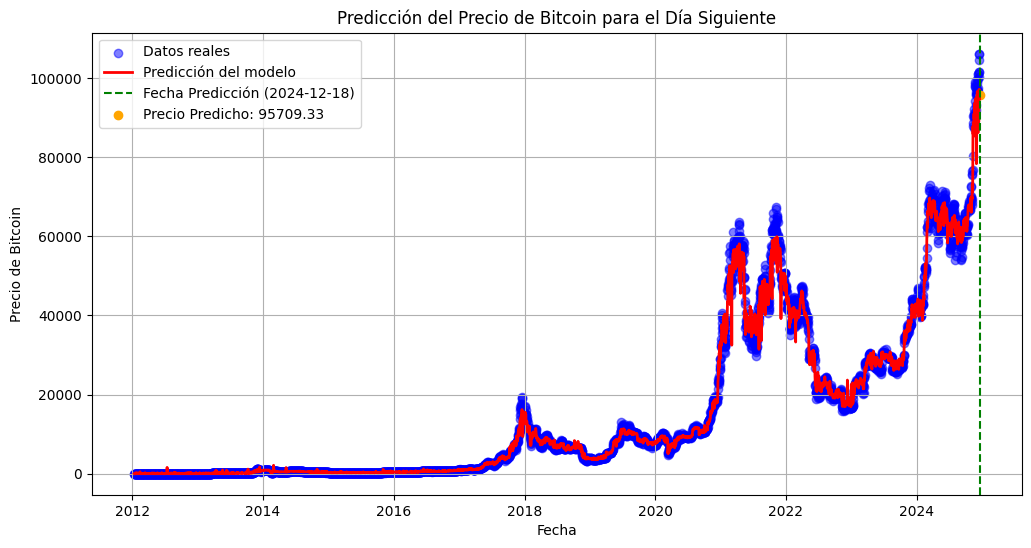

El precio predicho del Bitcoin para el día 2024-12-18 es: 95709.33


In [16]:
# Graficar resultados
plt.figure(figsize=(12, 6))

# Gráfica de los datos reales
plt.scatter(df['Fecha'], df['Último'], color='blue', label='Datos reales', alpha=0.5)

# Gráfica de las predicciones del modelo sobre los datos históricos
predicciones_historicas_rf = model_rf.predict(X)
plt.plot(df['Fecha'], predicciones_historicas_rf, color='red', label='Predicción del modelo', linewidth=2)

# Punto para la predicción del día siguiente
plt.axvline(x=proxima_fecha, color='green', linestyle='--', label=f'Fecha Predicción ({proxima_fecha.date()})')
plt.scatter(proxima_fecha, precio_predicho_rf, color='orange', label=f'Precio Predicho: {precio_predicho_rf:.2f}')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Precio de Bitcoin')
plt.title('Predicción del Precio de Bitcoin para el Día Siguiente')
plt.legend()
plt.grid()
plt.show()

# Mostrar el precio predicho
print(f"El precio predicho del Bitcoin para el día {proxima_fecha.date()} es: {precio_predicho_rf:.2f}")

- Ultimo, queremos añadir otra variable a elegir y tenga una explicacion(volumen)